## Compare Logistic Regression in the case of binary class (Sell, Buy)

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    ConfusionMatrixDisplay,
    classification_report,
    confusion_matrix,
)
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

In [2]:
# Get underlying prices
spy = pd.read_csv("../data/raw/spy.csv", parse_dates=True, index_col=0)

In [3]:
target = pd.read_csv("../data/processed/target_df.csv", index_col=0)["target"]

In [4]:
# Get the working dataframe
ml_df = pd.read_csv("../data/processed/ml_df.csv", parse_dates=True, index_col=0)

In [5]:
wk_df = pd.read_csv("../data/processed/exp_price.csv", parse_dates=True, index_col=0)

In [6]:
interest_rate = wk_df["r"].values

### Functions

In [7]:
def display_report(y_test: np.ndarray, predictions: np.ndarray) -> None:
    print(classification_report(y_test, predictions))
    cm = confusion_matrix(y_test, predictions)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot()
    plt.show()
    return

In [8]:
def plot_feature_imp(coefficients: np.ndarray[float], columns: list[str]) -> None:
    feature_importance = pd.DataFrame(
        {"Feature": columns, "Importance": np.abs(coefficients)}
    )
    feature_importance = feature_importance.sort_values("Importance", ascending=True)
    feature_importance.plot(x="Feature", y="Importance", kind="barh", figsize=(10, 6))
    plt.show()
    return

## Baseline Logistic Regression Classifier without new data + r

In [9]:
orig_df = ml_df[
    [
        "UNDERLYING_LAST",
        "STRIKE",
        "C_LAST",
        "C_BID",
        "C_ASK",
        "C_IV",
        "C_VOLUME",
        "diff_date",
    ]
].copy()

In [10]:
orig_df["r"] = interest_rate

### In sample predictions

In [11]:
X_train, X_test, y_train, y_test = train_test_split(
    orig_df, target.values.flatten(), test_size=0.2, random_state=1968, shuffle=True
)

In [12]:
params = {
    "random_state": 1968,
    "penalty": "l1",
    "solver": "liblinear",
    "C": 20.433597178569418,
} | {"verbose": 1}

In [13]:
pipe = Pipeline(
    [
        ("imputer", SimpleImputer(strategy="constant", fill_value=0.0)),
        ("scaler", StandardScaler()),
        ("rf", LogisticRegression(**params)),
    ]
)

In [14]:
# Fit the tuned model
pipe.fit(X_train, y_train)

[LibLinear]iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 2
iter   4  #CD cycles 1
iter   5  #CD cycles 23
iter   6  #CD cycles 7
iter   7  #CD cycles 1
iter   8  #CD cycles 832
iter   9  #CD cycles 32
iter  10  #CD cycles 4
iter  11  #CD cycles 58
iter  12  #CD cycles 136
iter  13  #CD cycles 356
iter  14  #CD cycles 52
iter  15  #CD cycles 3
iter  16  #CD cycles 52
iter  17  #CD cycles 2
iter  18  #CD cycles 7
iter  19  #CD cycles 6
iter  20  #CD cycles 3
iter  21  #CD cycles 12
iter  22  #CD cycles 12
iter  23  #CD cycles 20
iter  24  #CD cycles 21
iter  25  #CD cycles 9
iter  26  #CD cycles 22
iter  27  #CD cycles 22
iter  28  #CD cycles 34
iter  29  #CD cycles 1
iter  30  #CD cycles 1000
iter  31  #CD cycles 1000
iter  32  #CD cycles 1000
iter  33  #CD cycles 1000
iter  34  #CD cycles 896
iter  35  #CD cycles 105
iter  36  #CD cycles 33
iter  37  #CD cycles 1
iter  38  #CD cycles 1000
iter  39  #CD cycles 1000
iter  40  #CD cycles 1000
iter  41  #CD cycles 1000

Pipeline(steps=[('imputer', SimpleImputer(fill_value=0.0, strategy='constant')),
                ('scaler', StandardScaler()),
                ('rf',
                 LogisticRegression(C=20.433597178569418, penalty='l1',
                                    random_state=1968, solver='liblinear',
                                    verbose=1))])

In [15]:
predictions = pipe.predict(X_test)

In [16]:
pipe.score(X_test, y_test)

0.6254980079681275

              precision    recall  f1-score   support

           0       0.59      0.77      0.67       123
           1       0.69      0.48      0.57       128

    accuracy                           0.63       251
   macro avg       0.64      0.63      0.62       251
weighted avg       0.64      0.63      0.62       251



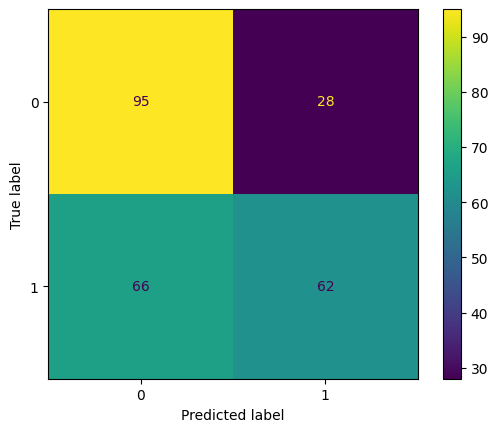

In [17]:
display_report(y_test, predictions)

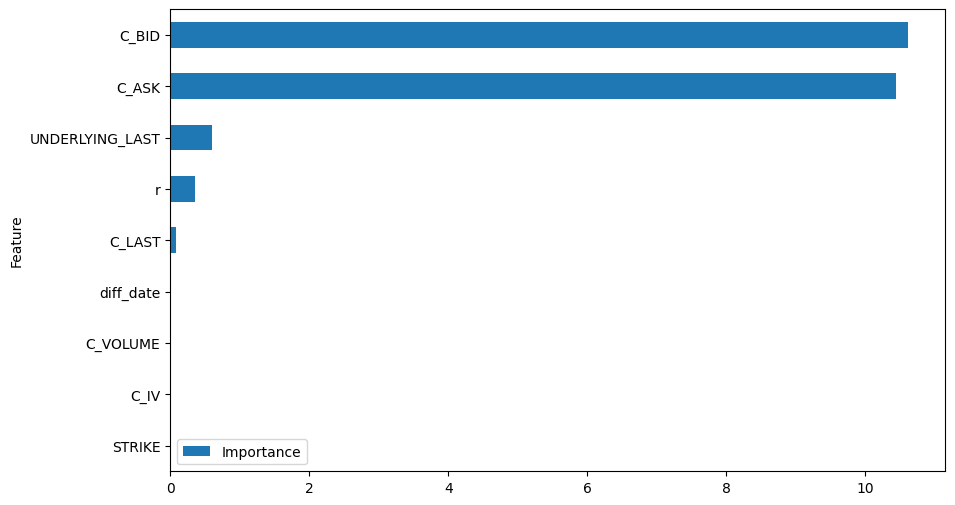

In [19]:
coefficients = pipe.named_steps["rf"].coef_[0]
columns = X_train.columns
plot_feature_imp(coefficients, columns)

In [20]:
compare_df = pd.DataFrame(predictions, columns=["bare_rf_pred_in"])

### Backtesting

In [21]:
strategy = []
date_idx = []
prev_price = 0.0
for x, i in enumerate(range(len(predictions), 0, -1)):
    row = X_test.iloc[-i, :].to_dict()
    quote_date = X_test.index[-i]
    exp_date = pd.to_datetime(ml_df.loc[quote_date, "EXPIRE_DATE"])
    # Needed since a day in YF is missing
    try:
        final_price = spy.loc[exp_date, "Close"]
    except KeyError:
        final_price = prev_price
    prev_price = final_price
    call_price = row["C_LAST"]
    strike = row["STRIKE"]
    if predictions[x]:  # buy
        if final_price > strike:
            profit = final_price - (strike + call_price)
        else:
            profit = -call_price
        res = {
            "strategy": predictions[x],
            "strike": strike,
            "call_price": row["C_LAST"],
            "exp_date": ml_df.loc[quote_date, "EXPIRE_DATE"],
            "final_price": final_price,
            "profit": profit,
            "bare": max(final_price - (strike + call_price), -call_price),
        }
    else:
        res = {
            "strategy": predictions[x],
            "strike": strike,
            "call_price": row["C_LAST"],
            "exp_date": ml_df.loc[quote_date, "EXPIRE_DATE"],
            "final_price": final_price,
            "profit": 0.0,
            "bare": max(final_price - (strike + call_price), -call_price),
        }
    strategy.append(res)
    date_idx.append(quote_date)

In [22]:
strategy_df = pd.DataFrame(strategy, pd.Index(name="Date", data=date_idx))

strategy_df = strategy_df.sort_index()

In [23]:
strategy_df["cum_profit"] = np.cumsum(strategy_df.profit.values)
strategy_df["cum_bare"] = np.cumsum(strategy_df.bare.values)

In [24]:
strategy_df

,strategy,strike,call_price,exp_date,final_price,profit,bare,cum_profit,cum_bare
Date,,,,,,,,,
2018-02-05,0,265.0,8.22,2018-02-28,271.649994,0.000000,-1.570006,0.000000,-1.570006
2018-02-22,1,270.0,4.26,2018-03-14,275.299988,1.039988,1.039988,1.039988,-0.530018
2018-03-08,1,274.0,2.85,2018-03-29,263.149994,-2.850000,-2.850000,-1.810012,-3.380018
2018-03-09,1,279.0,2.47,2018-03-29,263.149994,-2.470000,-2.470000,-4.280012,-5.850018
2018-04-03,1,260.5,5.09,2018-04-23,266.570007,0.980007,0.980007,-3.300005,-4.870011
...,...,...,...,...,...,...,...,...,...
2022-10-25,0,385.0,10.50,2022-11-14,395.119995,0.000000,-0.380005,421.770040,389.189830
2022-11-01,0,385.0,9.48,2022-11-21,394.589996,0.000000,0.109996,421.770040,389.299827
2022-11-02,0,375.0,10.19,2022-11-23,402.420013,0.000000,17.230013,421.770040,406.529840


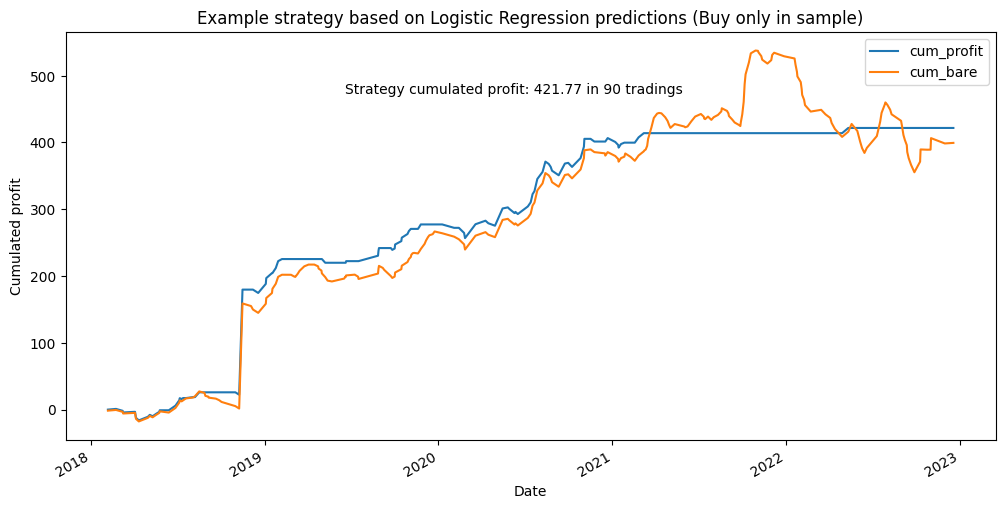

In [25]:
strategy_df[["cum_profit", "cum_bare"]].plot(
    figsize=(12, 6),
    ylabel="Cumulated profit",
    title="Example strategy based on Logistic Regression predictions (Buy only in sample)",
)
ax = plt.gca()
text = f"Strategy cumulated profit: {strategy_df['cum_profit'].iloc[-1]:.2f} in {strategy_df['strategy'].sum()} tradings"
plt.text(0.3, 0.85, text, transform=ax.transAxes)
plt.legend()
plt.show()

### Out-of-sample predictions

In [26]:
X_train, X_test, y_train, y_test = train_test_split(
    orig_df.values,
    target.values.flatten(),
    test_size=0.2,
    random_state=1968,
    shuffle=False,
)

In [27]:
pipe = Pipeline(
    [
        ("imputer", SimpleImputer(strategy="constant", fill_value=0.0)),
        ("scaler", StandardScaler()),
        ("rf", LogisticRegression(**params)),
    ]
)

In [28]:
# Fit the tuned model
pipe.fit(X_train, y_train)

[LibLinear]iter   1  #CD cycles 1
iter   2  #CD cycles 2
iter   3  #CD cycles 1
iter   4  #CD cycles 6
iter   5  #CD cycles 2
iter   6  #CD cycles 1
iter   7  #CD cycles 20
iter   8  #CD cycles 8
iter   9  #CD cycles 1
iter  10  #CD cycles 191
iter  11  #CD cycles 83
iter  12  #CD cycles 168
iter  13  #CD cycles 35
iter  14  #CD cycles 15
iter  15  #CD cycles 1
iter  16  #CD cycles 1000
iter  17  #CD cycles 1000
iter  18  #CD cycles 104
iter  19  #CD cycles 46
iter  20  #CD cycles 5
iter  21  #CD cycles 99
iter  22  #CD cycles 20
iter  23  #CD cycles 4
iter  24  #CD cycles 14
iter  25  #CD cycles 23
iter  26  #CD cycles 23
iter  27  #CD cycles 10
iter  28  #CD cycles 55
iter  29  #CD cycles 29
iter  30  #CD cycles 18
iter  31  #CD cycles 1
iter  32  #CD cycles 1000
iter  33  #CD cycles 1000
iter  34  #CD cycles 252
iter  35  #CD cycles 769
iter  36  #CD cycles 1
iter  37  #CD cycles 1000
iter  38  #CD cycles 1000
iter  39  #CD cycles 135
iter  40  #CD cycles 27
iter  41  #CD cycles 20


Pipeline(steps=[('imputer', SimpleImputer(fill_value=0.0, strategy='constant')),
                ('scaler', StandardScaler()),
                ('rf',
                 LogisticRegression(C=20.433597178569418, penalty='l1',
                                    random_state=1968, solver='liblinear',
                                    verbose=1))])

In [29]:
predictions = pipe.predict(X_test)

In [30]:
pipe.score(X_test, y_test)

0.50199203187251

              precision    recall  f1-score   support

           0       0.74      0.46      0.56       177
           1       0.32      0.61      0.42        74

    accuracy                           0.50       251
   macro avg       0.53      0.53      0.49       251
weighted avg       0.61      0.50      0.52       251



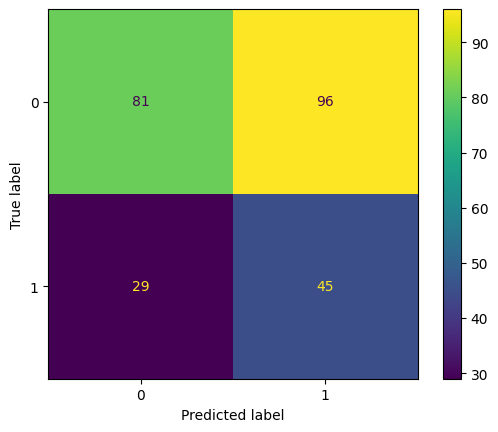

In [31]:
display_report(y_test, predictions)

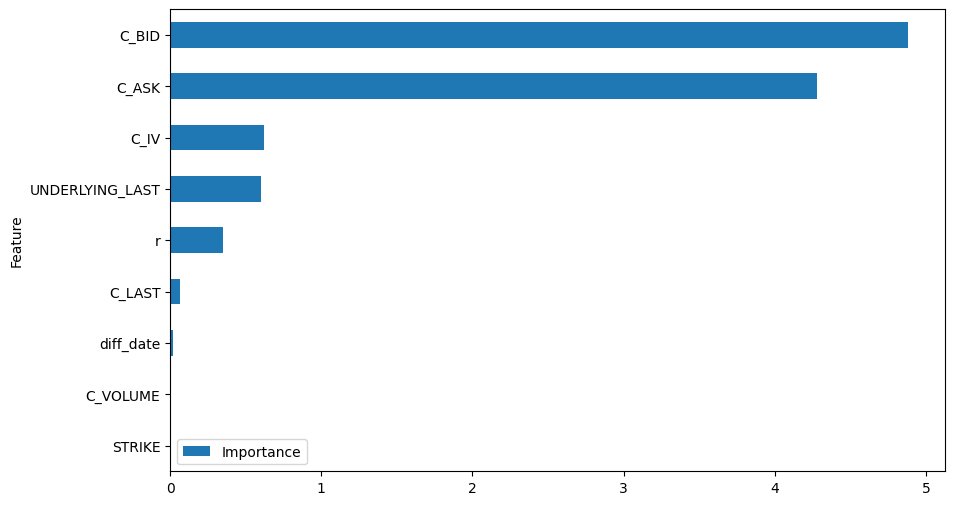

In [33]:
coefficients = pipe.named_steps["rf"].coef_[0]
columns = orig_df.columns
plot_feature_imp(coefficients, columns)

In [34]:
compare_df["bare_rf_pred_out"] = predictions

### Backtest strategy

In [35]:
strategy = []
date_idx = []
for x, i in enumerate(range(len(predictions), 0, -1)):
    row = orig_df.iloc[-i, :].to_dict()
    quote_date = orig_df.index[-i]
    exp_date = pd.to_datetime(ml_df.loc[quote_date, "EXPIRE_DATE"])
    final_price = spy.loc[exp_date, "Close"]
    call_price = row["C_LAST"]
    strike = row["STRIKE"]
    if predictions[x]:  # buy
        if final_price > strike:
            profit = final_price - (strike + call_price)
        else:
            profit = -call_price
        res = {
            "strategy": predictions[x],
            "strike": strike,
            "call_price": row["C_LAST"],
            "exp_date": ml_df.loc[quote_date, "EXPIRE_DATE"],
            "final_price": final_price,
            "profit": profit,
            "bare": max(final_price - (strike + call_price), -call_price),
        }
    else:
        res = {
            "strategy": predictions[x],
            "strike": strike,
            "call_price": row["C_LAST"],
            "exp_date": ml_df.loc[quote_date, "EXPIRE_DATE"],
            "final_price": final_price,
            "profit": 0.0,
            "bare": max(final_price - (strike + call_price), -call_price),
        }
    strategy.append(res)
    date_idx.append(quote_date)

In [36]:
strategy_df = pd.DataFrame(strategy, pd.Index(name="Date", data=date_idx))

In [37]:
strategy_df["cum_profit"] = np.cumsum(strategy_df.profit.values)
strategy_df["cum_bare"] = np.cumsum(strategy_df.bare.values)

In [38]:
strategy_df

,strategy,strike,call_price,exp_date,final_price,profit,bare,cum_profit,cum_bare
Date,,,,,,,,,
2022-01-03,0,478.0,4.81,2022-01-24,439.839996,0.00,-4.810000,0.000000,-4.810000
2022-01-04,0,478.0,4.80,2022-01-24,439.839996,0.00,-4.800000,0.000000,-9.610000
2022-01-05,1,468.0,8.14,2022-01-26,433.380005,-8.14,-8.140000,-8.140000,-17.750000
2022-01-06,0,468.0,7.00,2022-01-26,433.380005,0.00,-7.000000,-8.140000,-24.750000
2022-01-07,0,466.0,7.56,2022-01-28,441.950012,0.00,-7.560000,-8.140000,-32.310000
...,...,...,...,...,...,...,...,...,...
2022-12-23,0,383.0,8.00,2023-01-13,398.500000,0.00,7.500000,-237.820042,-525.980022
2022-12-26,0,383.0,7.96,2023-01-13,398.500000,0.00,7.540000,-237.820042,-518.440022
2022-12-28,0,377.0,8.75,2023-01-20,395.880005,0.00,10.130005,-237.820042,-508.310017


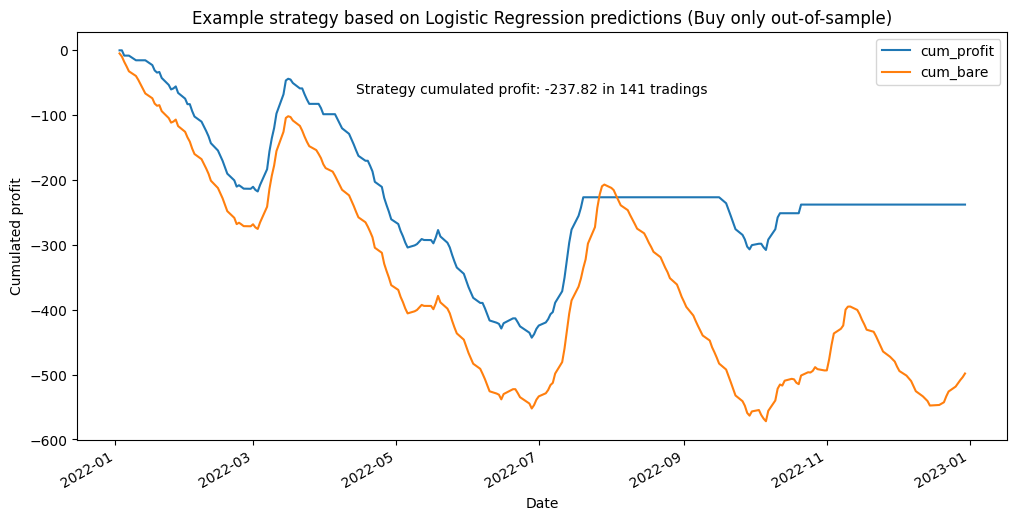

In [39]:
strategy_df[["cum_profit", "cum_bare"]].plot(
    figsize=(12, 6),
    ylabel="Cumulated profit",
    title="Example strategy based on Logistic Regression predictions (Buy only out-of-sample)",
)
ax = plt.gca()
text = f"Strategy cumulated profit: {strategy_df['cum_profit'].iloc[-1]:.2f} in {strategy_df['strategy'].sum()} tradings"
plt.text(0.3, 0.85, text, transform=ax.transAxes)
plt.legend()
plt.show()

## Logistic Regression with data from MC simulation and additional features

In [40]:
new_df = pd.concat(
    (
        ml_df[
            [
                "UNDERLYING_LAST",
                "STRIKE",
                "C_LAST",
                "C_BID",
                "C_ASK",
                "C_IV",
                "C_VOLUME",
                "diff",
            ]
        ],
        wk_df.drop(["last_quote", "strike"], axis=1),
    ),
    axis=1,
)

In [41]:
# Add some features
new_df["iqr"] = new_df["exp_price_q3"] - new_df["exp_price_q1"]
new_df["diff_call"] = new_df["exp_call_price"] - new_df["C_LAST"]
new_df["exp_price_var"] = np.power(new_df["exp_price_std"], 2)
new_df["exp_profit"] = new_df["exp_price"] - (new_df["STRIKE"] + new_df["C_LAST"])

### In sample predictions

In [42]:
X_train, X_test, y_train, y_test = train_test_split(
    new_df, target.values.flatten(), test_size=0.2, random_state=1968, shuffle=True
)

In [43]:
params = {
    "random_state": 1968,
    "max_iter": 1000,
    "penalty": "l2",
    "solver": "lbfgs",
    "C": 0.6210169418915616,
} | {"verbose": 1}

In [44]:
pipe = Pipeline(
    [
        ("imputer", SimpleImputer(strategy="constant", fill_value=0.0)),
        ("scaler", StandardScaler()),
        ("rf", LogisticRegression(**params)),
    ]
)

In [45]:
# Fit the tuned model
pipe.fit(X_train, y_train)

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           26     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.94533D+02    |proj g|=  7.97820D+01

At iterate   50    f=  6.66179D+02    |proj g|=  7.37489D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   26     63     71      1     0     0   1.332D-02   6.662D+02
  F =   666.17902286045251     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


 This problem is unconstrained.


Pipeline(steps=[('imputer', SimpleImputer(fill_value=0.0, strategy='constant')),
                ('scaler', StandardScaler()),
                ('rf',
                 LogisticRegression(C=0.6210169418915616, max_iter=1000,
                                    random_state=1968, verbose=1))])

In [46]:
predictions = pipe.predict(X_test)

In [47]:
pipe.score(X_test, y_test)

0.5856573705179283

              precision    recall  f1-score   support

           0       0.56      0.76      0.64       123
           1       0.65      0.41      0.50       128

    accuracy                           0.59       251
   macro avg       0.60      0.59      0.57       251
weighted avg       0.60      0.59      0.57       251



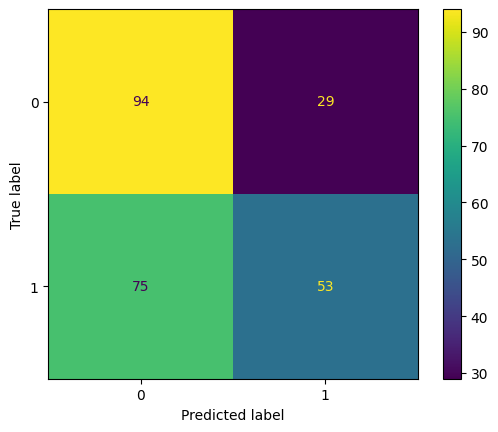

In [48]:
display_report(y_test, predictions)

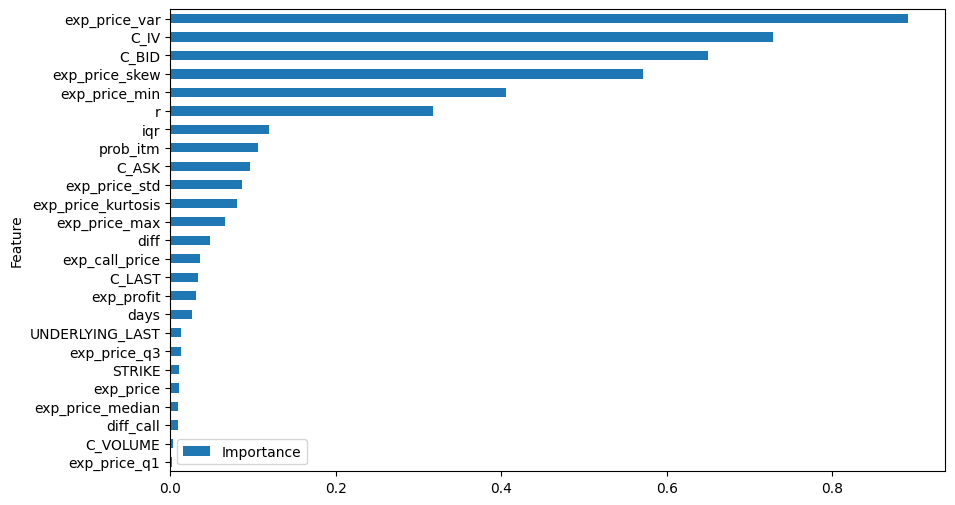

In [49]:
coefficients = pipe.named_steps["rf"].coef_[0]
columns = new_df.columns
plot_feature_imp(coefficients, columns)

In [50]:
compare_df["mmar_rf_pred_in"] = predictions

### Backtesting

In [51]:
strategy = []
date_idx = []
prev_price = 0.0
for x, i in enumerate(range(len(predictions), 0, -1)):
    row = X_test.iloc[-i, :].to_dict()
    quote_date = X_test.index[-i]
    exp_date = pd.to_datetime(ml_df.loc[quote_date, "EXPIRE_DATE"])
    # Needed since a day in YF is missing
    try:
        final_price = spy.loc[exp_date, "Close"]
    except KeyError:
        final_price = prev_price
    prev_price = final_price
    call_price = row["C_LAST"]
    strike = row["STRIKE"]
    if predictions[x]:  # buy
        if final_price > strike:
            profit = final_price - (strike + call_price)
        else:
            profit = -call_price
        res = {
            "strategy": predictions[x],
            "strike": strike,
            "call_price": row["C_LAST"],
            "exp_call": row["exp_call_price"],
            "exp_date": ml_df.loc[quote_date, "EXPIRE_DATE"],
            "final_price": final_price,
            "profit": profit,
            "bare": max(final_price - (strike + call_price), -call_price),
        }
    else:
        res = {
            "strategy": predictions[x],
            "strike": strike,
            "call_price": row["C_LAST"],
            "exp_call": row["exp_call_price"],
            "exp_date": ml_df.loc[quote_date, "EXPIRE_DATE"],
            "final_price": final_price,
            "profit": 0.0,
            "bare": max(final_price - (strike + call_price), -call_price),
        }
    strategy.append(res)
    date_idx.append(quote_date)

In [52]:
strategy_df = pd.DataFrame(strategy, pd.Index(name="Date", data=date_idx))

strategy_df = strategy_df.sort_index()

In [53]:
strategy_df["cum_profit"] = np.cumsum(strategy_df.profit.values)
strategy_df["cum_bare"] = np.cumsum(strategy_df.bare.values)

In [54]:
strategy_df

,strategy,strike,call_price,exp_call,exp_date,final_price,profit,bare,cum_profit,cum_bare
Date,,,,,,,,,,
2018-02-05,0,265.0,8.22,4.942161,2018-02-28,271.649994,0.000000,-1.570006,0.000000,-1.570006
2018-02-22,1,270.0,4.26,6.397086,2018-03-14,275.299988,1.039988,1.039988,1.039988,-0.530018
2018-03-08,1,274.0,2.85,5.917690,2018-03-29,263.149994,-2.850000,-2.850000,-1.810012,-3.380018
2018-03-09,1,279.0,2.47,5.505012,2018-03-29,263.149994,-2.470000,-2.470000,-4.280012,-5.850018
2018-04-03,1,260.5,5.09,5.247430,2018-04-23,266.570007,0.980007,0.980007,-3.300005,-4.870011
...,...,...,...,...,...,...,...,...,...,...
2022-10-25,0,385.0,10.50,9.062317,2022-11-14,395.119995,0.000000,-0.380005,380.610067,389.189830
2022-11-01,0,385.0,9.48,8.719475,2022-11-21,394.589996,0.000000,0.109996,380.610067,389.299827
2022-11-02,0,375.0,10.19,8.901524,2022-11-23,402.420013,0.000000,17.230013,380.610067,406.529840


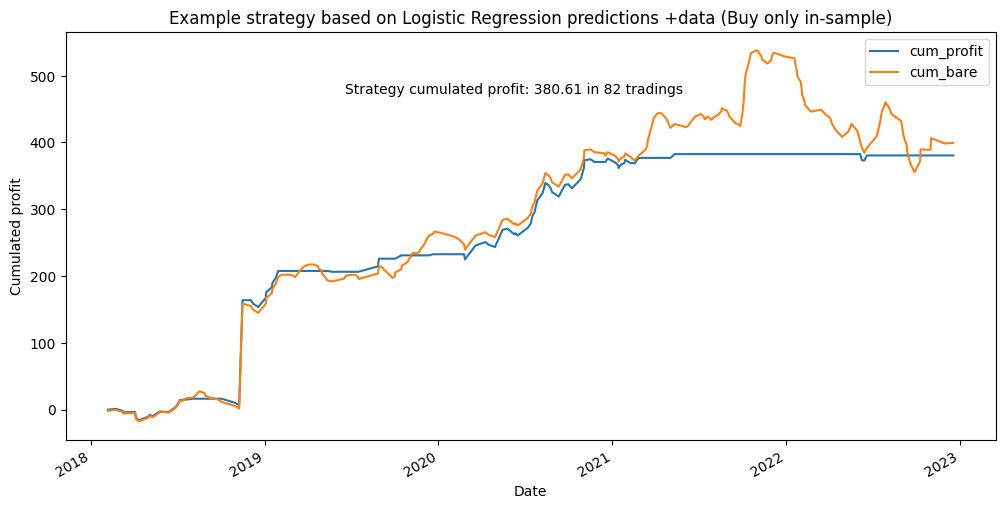

In [55]:
strategy_df[["cum_profit", "cum_bare"]].plot(
    figsize=(12, 6),
    ylabel="Cumulated profit",
    title="Example strategy based on Logistic Regression predictions +data (Buy only in-sample)",
)
ax = plt.gca()
text = f"Strategy cumulated profit: {strategy_df['cum_profit'].iloc[-1]:.2f} in {strategy_df['strategy'].sum()} tradings"
plt.text(0.3, 0.85, text, transform=ax.transAxes)
plt.legend()
plt.show()

### Out-of-sample predictions

In [56]:
X_train, X_test, y_train, y_test = train_test_split(
    new_df.values,
    target.values.flatten(),
    test_size=0.2,
    random_state=1968,
    shuffle=False,
)

In [57]:
pipe = Pipeline(
    [
        ("imputer", SimpleImputer(strategy="constant", fill_value=0.0)),
        ("scaler", StandardScaler()),
        ("rf", LogisticRegression(**params)),
    ]
)

In [58]:
# Fit the tuned model
pipe.fit(X_train, y_train)

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           26     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.94533D+02    |proj g|=  6.34813D+01

At iterate   50    f=  6.71029D+02    |proj g|=  1.42027D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   26     80     90      1     0     0   2.332D-02   6.710D+02
  F =   671.02655073212202     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


 This problem is unconstrained.


Pipeline(steps=[('imputer', SimpleImputer(fill_value=0.0, strategy='constant')),
                ('scaler', StandardScaler()),
                ('rf',
                 LogisticRegression(C=0.6210169418915616, max_iter=1000,
                                    random_state=1968, verbose=1))])

In [59]:
predictions = pipe.predict(X_test)

In [60]:
pipe.score(X_test, y_test)

0.450199203187251

              precision    recall  f1-score   support

           0       0.72      0.36      0.48       177
           1       0.30      0.68      0.42        74

    accuracy                           0.45       251
   macro avg       0.51      0.52      0.45       251
weighted avg       0.60      0.45      0.46       251



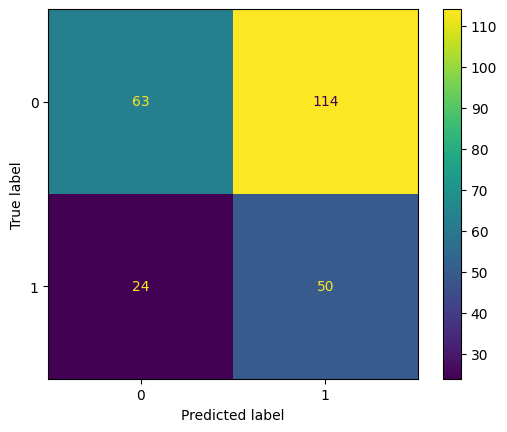

In [61]:
display_report(y_test, predictions)

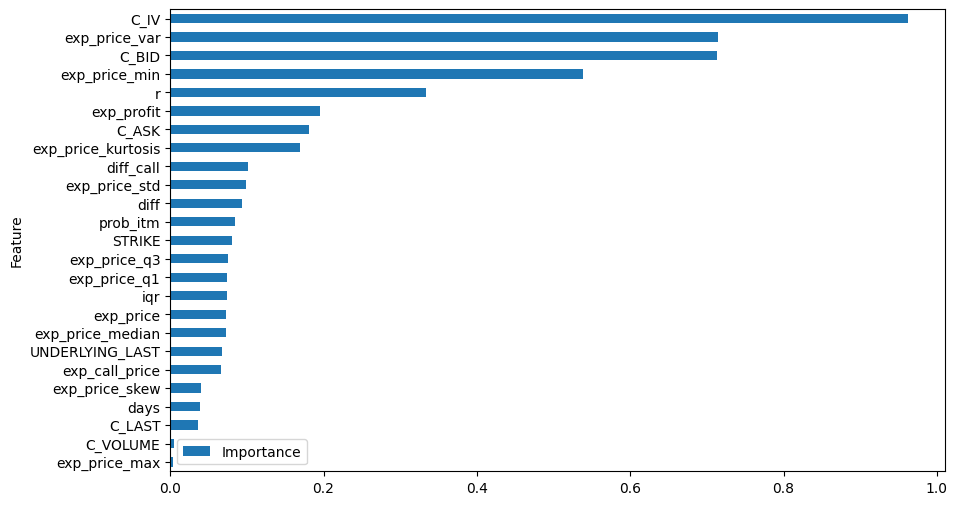

In [62]:
coefficients = pipe.named_steps["rf"].coef_[0]
columns = new_df.columns
plot_feature_imp(coefficients, columns)

In [63]:
compare_df["mmar_rf_pred_out"] = predictions

### Backtest strategy

In [64]:
strategy = []
date_idx = []
for x, i in enumerate(range(len(predictions), 0, -1)):
    row = new_df.iloc[-i, :].to_dict()
    quote_date = new_df.index[-i]
    exp_date = pd.to_datetime(ml_df.loc[quote_date, "EXPIRE_DATE"])
    final_price = spy.loc[exp_date, "Close"]
    call_price = row["C_LAST"]
    strike = row["STRIKE"]
    if predictions[x]:  # buy
        if final_price > strike:
            profit = final_price - (strike + call_price)
        else:
            profit = -call_price
        res = {
            "strategy": predictions[x],
            "strike": strike,
            "call_price": row["C_LAST"],
            "exp_call": row["exp_call_price"],
            "exp_date": ml_df.loc[quote_date, "EXPIRE_DATE"],
            "final_price": final_price,
            "profit": profit,
            "bare": max(final_price - (strike + call_price), -call_price),
        }
    else:
        res = {
            "strategy": predictions[x],
            "strike": strike,
            "call_price": row["C_LAST"],
            "exp_call": row["exp_call_price"],
            "exp_date": ml_df.loc[quote_date, "EXPIRE_DATE"],
            "final_price": final_price,
            "profit": 0.0,
            "bare": max(final_price - (strike + call_price), -call_price),
        }
    strategy.append(res)
    date_idx.append(quote_date)

In [65]:
strategy_df = pd.DataFrame(strategy, pd.Index(name="Date", data=date_idx))

In [66]:
strategy_df["cum_profit"] = np.cumsum(strategy_df.profit.values)
strategy_df["cum_bare"] = np.cumsum(strategy_df.bare.values)

In [67]:
strategy_df

,strategy,strike,call_price,exp_call,exp_date,final_price,profit,bare,cum_profit,cum_bare
Date,,,,,,,,,,
2022-01-03,1,478.0,4.81,10.248337,2022-01-24,439.839996,-4.81,-4.810000,-4.810000,-4.810000
2022-01-04,0,478.0,4.80,9.610177,2022-01-24,439.839996,0.00,-4.800000,-4.810000,-9.610000
2022-01-05,1,468.0,8.14,10.191128,2022-01-26,433.380005,-8.14,-8.140000,-12.950000,-17.750000
2022-01-06,1,468.0,7.00,9.657596,2022-01-26,433.380005,-7.00,-7.000000,-19.950000,-24.750000
2022-01-07,1,466.0,7.56,9.927762,2022-01-28,441.950012,-7.56,-7.560000,-27.510000,-32.310000
...,...,...,...,...,...,...,...,...,...,...
2022-12-23,0,383.0,8.00,8.453400,2023-01-13,398.500000,0.00,7.500000,-271.140007,-525.980022
2022-12-26,0,383.0,7.96,8.096501,2023-01-13,398.500000,0.00,7.540000,-271.140007,-518.440022
2022-12-28,0,377.0,8.75,8.526141,2023-01-20,395.880005,0.00,10.130005,-271.140007,-508.310017


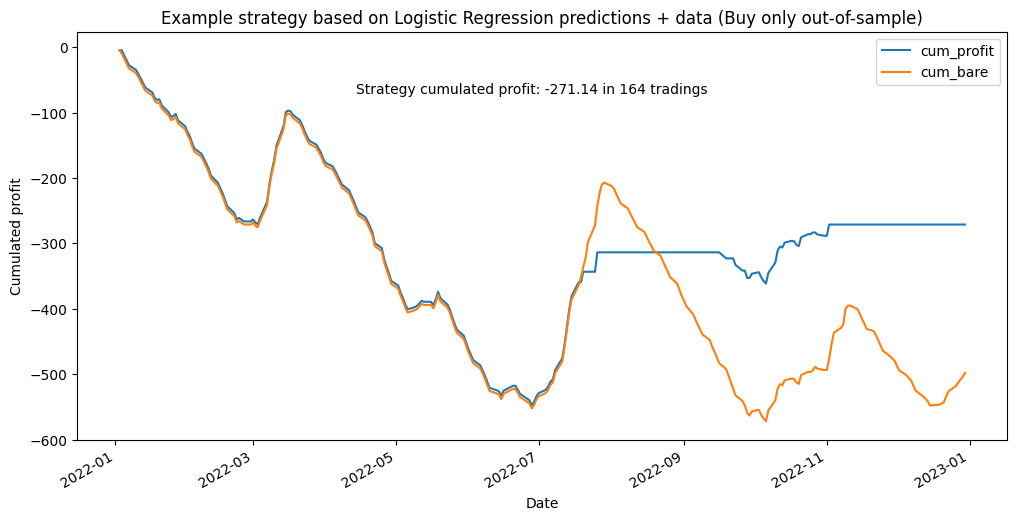

In [68]:
strategy_df[["cum_profit", "cum_bare"]].plot(
    figsize=(12, 6),
    ylabel="Cumulated profit",
    title="Example strategy based on Logistic Regression predictions + data (Buy only out-of-sample)",
)
ax = plt.gca()
text = f"Strategy cumulated profit: {strategy_df['cum_profit'].iloc[-1]:.2f} in {strategy_df['strategy'].sum()} tradings"
plt.text(0.3, 0.85, text, transform=ax.transAxes)
plt.legend()
plt.show()

## Compare the two predictions

In [69]:
mask_in = (compare_df["bare_rf_pred_in"] - compare_df["mmar_rf_pred_in"]).astype(bool)
mask_out = (compare_df["bare_rf_pred_out"] - compare_df["mmar_rf_pred_out"]).astype(
    bool
)

In [70]:
# Compare in sample preds
compare_df[mask_in]

,bare_rf_pred_in,bare_rf_pred_out,mmar_rf_pred_in,mmar_rf_pred_out
4,1,0,0,1
13,0,1,1,1
14,1,1,0,1
15,1,1,0,1
26,0,1,1,1
30,0,1,1,1
31,1,1,0,1
32,1,1,0,1
43,1,1,0,1
47,0,1,1,1


In [71]:
compare_df[mask_in].shape

(30, 4)

In [72]:
# Compare out of sample preds
compare_df[mask_out]

,bare_rf_pred_in,bare_rf_pred_out,mmar_rf_pred_in,mmar_rf_pred_out
0,0,0,0,1
3,0,0,0,1
4,1,0,0,1
6,0,0,0,1
7,1,0,1,1
8,0,0,0,1
9,1,0,1,1
22,1,0,1,1
56,0,0,0,1
60,0,0,1,1


In [73]:
compare_df[mask_out].shape

(35, 4)

In [74]:
compare_df.sum(axis=0)

bare_rf_pred_in      90
bare_rf_pred_out    141
mmar_rf_pred_in      82
mmar_rf_pred_out    164
dtype: int64